In [1]:
pip install pyDOE

Sequential(
  (0): Linear(in_features=2, out_features=20, bias=True)
  (1): Tanh()
  (2): Linear(in_features=20, out_features=20, bias=True)
  (3): Tanh()
  (4): Linear(in_features=20, out_features=20, bias=True)
  (5): Tanh()
  (6): Linear(in_features=20, out_features=1, bias=True)
)
model parameters on gpu: False
Epoch (Adam): 0, Cost: 15.306591987609863
Epoch (Adam): 100, Cost: 15.284598350524902
Epoch (Adam): 200, Cost: 15.284268379211426
Epoch (Adam): 300, Cost: 15.28236198425293
Epoch (Adam): 400, Cost: 15.275819778442383
Epoch (Adam): 500, Cost: 15.260847091674805
Epoch (Adam): 600, Cost: 15.142818450927734
Epoch (Adam): 700, Cost: 10.234313011169434
Epoch (Adam): 800, Cost: 9.112717628479004
Epoch (Adam): 900, Cost: 9.016331672668457
Epoch (Adam): 1000, Cost: 8.763229370117188
Epoch (Adam): 1100, Cost: 8.408219337463379
Epoch (Adam): 1200, Cost: 8.238219261169434
Epoch (Adam): 1300, Cost: 8.117915153503418
Epoch (Adam): 1400, Cost: 8.026782035827637
Epoch (Adam): 1500, Cost: 7.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


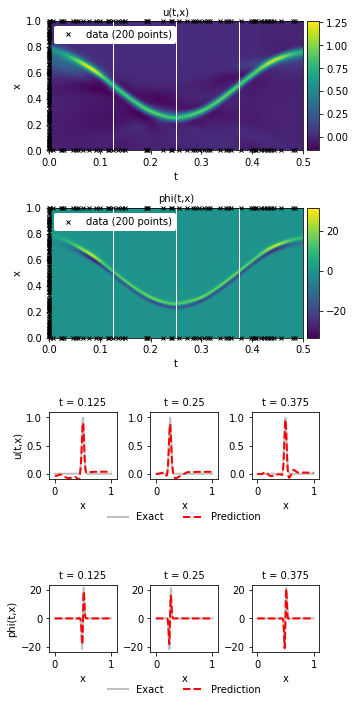

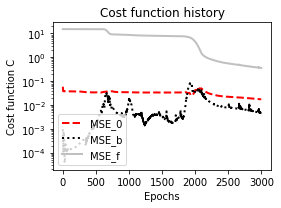

In [2]:
import time
import torch
import numpy as np
import scipy.io
from pyDOE import lhs
from physicsinformed import PhysicsInformedContinuous
from scipy.interpolate import griddata
import utilities

# Select gpu if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dtype = torch.float

# Set seed for the Random Number Generator (RNG), setting the seed generates same set of random numbers everytime 
torch.manual_seed(0)
np.random.seed(0) 

# Define no. of training points
N0 = 100
N_b = 50
N_f = 20000

# Define feed-forward network architecture
layers = [2, 20, 20, 20, 1]

# Define no. of epochs for each optimizer
epochs_Adam = 3000
epochs_LBFGS = 1000

### PRE-PROCESSING ###
# Loading benchmark data
data = scipy.io.loadmat('heat1Dscript.mat')
t = data['ts'].flatten()[:, None]
x = data['xs'].flatten()[:, None]
u_sol = data['usol'].T
flux_sol = data['fluxsol'].T

X, T = np.meshgrid(x, t) # Creates mesh such that for every xi, all the ti s can be accessed and vice-versa

# Transform grid into vectors that can be processed by the neural net
X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None])) #Stack arrays in sequence horizontally (column wise)
u_star = u_sol.flatten()[:, None]
flux_star = flux_sol.flatten()[:, None]

# Domain bounds
lb = X_star.min(0)
ub = X_star.max(0)

# Select random data points for the initial condition
idx_x = np.random.choice(x.shape[0], N0, replace=False) # Choose random 100 indices from 256 total indices of space
x0 = x[idx_x, :] # location of these 100 random points
u0 = torch.tensor(u_sol.T[idx_x, 0:1], dtype=dtype, device=device) # Choose temperatures of 100 random points at t=0

# Select random data points for the boundary condition
idx_t = np.random.choice(t.shape[0], N_b, replace=False) # Choose random 50 indices from 201 total indices of time
tb = t[idx_t, :] # time stamps of those 50 indices

# Create collocation points with latin hypercube sampling
X_f = lb + (ub - lb) * lhs(2, N_f) # Creates 20000 sample points in both x and t

X0 = np.concatenate((x0, 0 * x0), 1) # (x0, 0)
X_lb = np.concatenate((0 * tb + lb[0], tb), 1) # (lb[0], tb)
X_ub = np.concatenate((0 * tb + ub[0], tb), 1) # (ub[0], tb)

### TRAINING ###
# Create torch.tensors of training data
x0 = torch.tensor(X0[:, 0:1], dtype=dtype, requires_grad=True, device=device)
t0 = torch.tensor(X0[:, 1:2], dtype=dtype, requires_grad=True, device=device)

x_lb = torch.tensor(X_lb[:, 0:1], dtype=dtype, requires_grad=True, device=device)
t_lb = torch.tensor(X_lb[:, 1:2], dtype=dtype, requires_grad=True, device=device)

x_ub = torch.tensor(X_ub[:, 0:1], dtype=dtype, requires_grad=True, device=device)
t_ub = torch.tensor(X_ub[:, 1:2], dtype=dtype, requires_grad=True, device=device)

x_f = torch.tensor(X_f[:, 0:1], dtype=dtype, requires_grad=True, device=device)
t_f = torch.tensor(X_f[:, 1:2], dtype=dtype, requires_grad=True, device=device)

# Initialize PINN model
PINNModel = PhysicsInformedContinuous(layers, t0, x0, t_lb, x_lb, t_ub, x_ub, t_f, x_f, u0)

# Train the model
start_time = time.time()
PINNModel.train(epochs_Adam, optimizer='Adam', lr=0.001)
#PINNModel.train(epochs_LBFGS, optimizer='L-BFGS')
elapsed = time.time() - start_time
print('Training time: %.4f' % (elapsed))

# Create torch.tensors to predict solution for the whole domain
x_star = torch.tensor(X_star[:, 0:1], dtype=dtype, requires_grad=True, device=device)
t_star = torch.tensor(X_star[:, 1:2], dtype=dtype, requires_grad=False, device=device)

# Predict temperature distribution and first derivative for the heat flux
u_pred = PINNModel.u_nn(t_star, x_star)
u_x_pred = utilities.get_derivative(u_pred, x_star, 1)

### POST-PROCESSING ###
u_pred = u_pred.detach().cpu().numpy()
u_x_pred = u_x_pred.detach().cpu().numpy()

# Computing heat flux
k = u_pred
flux_pred = -k * u_x_pred

# Compute error measure
error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)
print('Error u: %e' % (error_u))

error_flux = np.linalg.norm(flux_star - flux_pred, 2) / np.linalg.norm(flux_star, 2)
print('Error flux: %e' % (error_flux))

u_pred_grid = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
error_u_abs = np.abs(u_sol - u_pred_grid)
flux_pred_grid = griddata(X_star, flux_pred.flatten(), (X, T), method='cubic')
error_flux_abs = np.abs(flux_sol - flux_pred_grid)

X_u_train = np.vstack([X0, X_lb, X_ub])
utilities.plot_results(t, x, u_pred_grid, flux_pred_grid, u_sol, flux_sol, X_u_train, lb, ub)

# Plot training history and predicitons
PINNModel.plot_training_history()

In [1]:
import torch

In [ ]:
torch.cuda.is_available()